In [1]:
import gc
import numpy as np
import pandas as pd
import xgboost as xgb
from tqdm.notebook import tqdm
#BASE = '../input/godaddy-microbusiness-density-forecasting/'
BASE = 'io/dataset/'

def smape(y_true, y_pred):
    smap = np.zeros(len(y_true))
    
    num = np.abs(y_true - y_pred)
    dem = ((np.abs(y_true) + np.abs(y_pred)) / 2)
    
    pos_ind = (y_true!=0)|(y_pred!=0)
    smap[pos_ind] = num[pos_ind] / dem[pos_ind]
    
    return 100 * np.mean(smap)

def vsmape(y_true, y_pred):
    smap = np.zeros(len(y_true))
    
    num = np.abs(y_true - y_pred)
    dem = ((np.abs(y_true) + np.abs(y_pred)) / 2)
    
    pos_ind = (y_true!=0)|(y_pred!=0)
    smap[pos_ind] = num[pos_ind] / dem[pos_ind]
    
    return 100 * smap


!ls io/dataset

census_starter.csv  sample_submission.csv  test.csv  train.csv


**QUESTION**

?? I haven't see anyone use census.csv

In [2]:
census = pd.read_csv(BASE + 'census_starter.csv')
print(census.columns)
census.head()

Index(['pct_bb_2017', 'pct_bb_2018', 'pct_bb_2019', 'pct_bb_2020',
       'pct_bb_2021', 'cfips', 'pct_college_2017', 'pct_college_2018',
       'pct_college_2019', 'pct_college_2020', 'pct_college_2021',
       'pct_foreign_born_2017', 'pct_foreign_born_2018',
       'pct_foreign_born_2019', 'pct_foreign_born_2020',
       'pct_foreign_born_2021', 'pct_it_workers_2017', 'pct_it_workers_2018',
       'pct_it_workers_2019', 'pct_it_workers_2020', 'pct_it_workers_2021',
       'median_hh_inc_2017', 'median_hh_inc_2018', 'median_hh_inc_2019',
       'median_hh_inc_2020', 'median_hh_inc_2021'],
      dtype='object')


,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,cfips,pct_college_2017,pct_college_2018,pct_college_2019,pct_college_2020,...,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021
0,76.6,78.9,80.6,82.7,85.5,1001,14.5,15.9,16.1,16.7,...,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0
1,74.5,78.1,81.8,85.1,87.9,1003,20.4,20.7,21.0,20.2,...,1.4,1.3,1.4,1.0,1.3,52562,55962.0,58320,61756.0,64346.0
2,57.2,60.4,60.5,64.6,64.6,1005,7.6,7.8,7.6,7.3,...,0.5,0.3,0.8,1.1,0.8,33368,34186.0,32525,34990.0,36422.0
3,62.0,66.1,69.2,76.1,74.6,1007,8.1,7.6,6.5,7.4,...,1.2,1.4,1.6,1.7,2.1,43404,45340.0,47542,51721.0,54277.0
4,65.8,68.5,73.0,79.6,81.0,1009,8.7,8.1,8.6,8.9,...,1.3,1.4,0.9,1.1,0.9,47412,48695.0,49358,48922.0,52830.0


---

# 1. Basic processing

In [3]:
train = pd.read_csv(BASE + 'train.csv')
test = pd.read_csv(BASE + 'test.csv')
sub = pd.read_csv(BASE + 'sample_submission.csv')
print(train.shape, test.shape, sub.shape)  # (122265, 7) (25080, 3) (25080, 2)

# 1. concatenate train and test
train['istest'] = 0
test['istest'] = 1
raw = pd.concat((train, test)).sort_values(['cfips','row_id']).reset_index(drop=True)
# concat train and test data, and sort by cfips first, and then sort by row_id for each cfips
# since row_id has a format 'cfips-first day of month', basically we sort by time
# because we have both train and test, the index is confounded. so we drop the index first and then give the joined table a new index from 0

# 2. change the type of the column 'first_day_of_month' to 'to_datetime'
raw['first_day_of_month'] = pd.to_datetime(raw["first_day_of_month"])

# 3. for each cfips, fill the 'county' and 'state' for the test part by forward fill
# - ffill: propagate last valid observation forward to next valid backfill
# - bfill: use next valid observation to fill gap.
raw['county'] = raw.groupby('cfips')['county'].ffill()
raw['state'] = raw.groupby('cfips')['state'].ffill()
# now, test data also have the 'county' and 'state' column value

# 4. - NEW COLUMNS: two year and month columns for both train and test
raw["year"] = raw["first_day_of_month"].dt.year
raw["month"] = raw["first_day_of_month"].dt.month

# 5. - NEW COLUMNS: for each cfips, give each month a unique index from 0 to length of that group - 1.
#                   dcount become the unique index for each month for a cfips.
#                   dcount is the 0-started index for each cfips
raw["dcount"] = raw.groupby(['cfips'])['row_id'].cumcount()

# 6. - NEW COLUMNS: encode 'county + state' as unique codes; encode 'state' as unique codes
raw['county_i'] = (raw['county'] + raw['state']).factorize()[0]
raw['state_i'] = raw['state'].factorize()[0]

(122265, 7) (25080, 3) (25080, 2)


In [4]:
raw

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest,year,month,dcount,county_i,state_i
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249.0,0,2019,8,0,0,0
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198.0,0,2019,9,1,0,0
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269.0,0,2019,10,2,0,0
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243.0,0,2019,11,3,0,0
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243.0,0,2019,12,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
147340,56045_2023-02-01,56045,Weston County,Wyoming,2023-02-01,NaN,NaN,1,2023,2,42,3134,50
147341,56045_2023-03-01,56045,Weston County,Wyoming,2023-03-01,NaN,NaN,1,2023,3,43,3134,50
147342,56045_2023-04-01,56045,Weston County,Wyoming,2023-04-01,NaN,NaN,1,2023,4,44,3134,50
147343,56045_2023-05-01,56045,Weston County,Wyoming,2023-05-01,NaN,NaN,1,2023,5,45,3134,50


---

# 2. Anomaly Detection

In [5]:
lag = 1

# .shift(lag): for each cfips, shift its density column by lag=1, so the density in each first row will be NAN. -> you get a column with the length = len('density')
# .bfill(): fill NaN with the next valid density, so the density in each cfips' first row will be the original value, but note that
#           1001's density from 2022-12-01 to 2023-06-01 will be back filled by the first density of 1003 (the next cfips), in this new column 'mbd_lag_1'.
#           but, it turns out that doesn't really matter
# NOTE THAT, in the engineering, 'mbd_lag_1' is overwrite by new feature
raw[f'mbd_lag_{lag}'] = raw.groupby('cfips')['microbusiness_density'].shift(lag).bfill()

# basically, 'dif' means the 'percentage increment' of the density from the previous month to this month
raw['dif'] = (raw['microbusiness_density'] / raw[f'mbd_lag_{lag}']).fillna(1).clip(0, None) - 1

# if there are zeros in density, then we need to deal with special cases:
#    density  mbd_lag_1  div  fillna  clip  diff
#       1         1       1                 -> 0   
#       2         1       2                 -> 1
#       0         2       0                 -> -1
#       0         0      inf                -> inf     special cases
#       4         0      inf                -> inf     special cases
#      Nan        4      Nan    -> 1        -> 0
#      Nan        Nan    Nan    -> 1        -> 0
#      Nan        Nan    Nan    -> 1        -> 0

# --------------------------------------------
raw.loc[(raw[f'mbd_lag_{lag}']==0), 'dif'] = 0
#    density  mbd_lag_1  div  fillna   diff
#       1         1       1          -> 0   
#       2         1       2          -> 1
#       0         2       0          -> -1
#       0         0      inf         -> inf     special cases -> 0
#       4         0      inf         -> inf     special cases -> 0
#      Nan        4      Nan    -> 1 -> 0
#      Nan        Nan    Nan    -> 1 -> 0
#      Nan        Nan    Nan    -> 1 -> 0


raw.loc[(raw[f'microbusiness_density']>0) & (raw[f'mbd_lag_{lag}']==0), 'dif'] = 1  
#    density  mbd_lag_1  div  fillna   diff
#       1         1       1          -> 0   
#       2         1       2          -> 1
#       0         2       0          -> -1
#       0         0      inf         -> inf     special cases -> 0
#       4         0      inf         -> inf     special cases -> 0 -> 1   # is 1 a reasonable number?
#      Nan        4      Nan    -> 1 -> 0
#      Nan        Nan    Nan    -> 1 -> 0
#      Nan        Nan    Nan    -> 1 -> 0

# -------------------------

raw['dif'] = raw['dif'].abs()

In [6]:
raw

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest,year,month,dcount,county_i,state_i,mbd_lag_1,dif
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249.0,0,2019,8,0,0,0,3.007682,0.000000
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198.0,0,2019,9,1,0,0,3.007682,0.040833
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269.0,0,2019,10,2,0,0,2.884870,0.059265
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243.0,0,2019,11,3,0,0,3.055843,0.020489
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243.0,0,2019,12,4,0,0,2.993233,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147340,56045_2023-02-01,56045,Weston County,Wyoming,2023-02-01,NaN,NaN,1,2023,2,42,3134,50,NaN,0.000000
147341,56045_2023-03-01,56045,Weston County,Wyoming,2023-03-01,NaN,NaN,1,2023,3,43,3134,50,NaN,0.000000
147342,56045_2023-04-01,56045,Weston County,Wyoming,2023-04-01,NaN,NaN,1,2023,4,44,3134,50,NaN,0.000000
147343,56045_2023-05-01,56045,Weston County,Wyoming,2023-05-01,NaN,NaN,1,2023,5,45,3134,50,NaN,0.000000


## Let's see which dcount (time point) has a SIGNIFINCANT increase than the previous month!

<AxesSubplot: xlabel='dcount'>

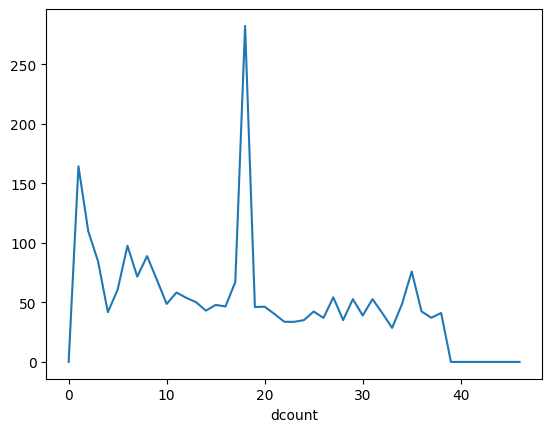

In [7]:
raw.groupby('dcount')['dif'].sum().plot()

<AxesSubplot: xlabel='first_day_of_month'>

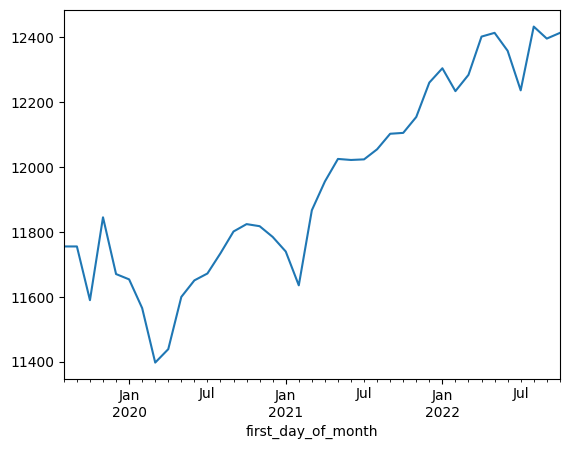

In [8]:
raw.query('istest == 0').groupby('first_day_of_month')['mbd_lag_1'].sum().plot()

## Smoothing & Outlier correction

In [9]:
outliers = []   # record which cfips has outliners
cnt = 0         # the tot num of outliners

for o in tqdm(raw.cfips.unique()):     # each cfips
    
    indices = (raw['cfips']==o)        # get all the idx for that cfips
    tmp = raw.loc[indices].copy().reset_index(drop=True)   # get all the rows for the cfips, reset_index make each tmp index from zero
    var = tmp.microbusiness_density.values.copy()          # copy density data for the current cfips
    #vmax = np.max(var[:38]) - np.min(var[:38])
    
    for i in range(37, 2, -1):         # idx 37 ~ 3. Note: 0 ~ 38 is training data
                                       # why not consider 38? 2?  # i think you can even set it to 0
        thr = 0.20*np.mean(var[:i])    # use 20% average of the points before current point i as the anomaly value TH
        difa = abs(var[i]-var[i-1])    # if the current point i's increase is bigger than thr, we consider it as a anomaly change, not natural trend
        if (difa>=thr):                # so we 'lift' all the previous values to the same 'stage' of the current point
            var[:i] *= (var[i]/var[i-1])
            
            outliers.append(o)         # save which cfips has outliers
            cnt+=1                     # total count
    
    # why not set the above for loop as range(37,0,-1)? so we don't need the line below
    var[0] = var[1]*0.99               # why do this hard code 0.99? make the first -> second unchanged almost? 
    
    raw.loc[indices, 'microbusiness_density'] = var  # the smoothed density
    
outliers = np.unique(outliers)
len(outliers), cnt

  0%|          | 0/3135 [00:00<?, ?it/s]

/tmp/ipykernel_882/4075535322.py:16: RuntimeWarning: invalid value encountered in double_scalars
  var[:i] *= (var[i]/var[i-1])
/tmp/ipykernel_882/4075535322.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  var[:i] *= (var[i]/var[i-1])
/tmp/ipykernel_882/4075535322.py:16: RuntimeWarning: invalid value encountered in multiply
  var[:i] *= (var[i]/var[i-1])
/tmp/ipykernel_882/4075535322.py:14: RuntimeWarning: invalid value encountered in double_scalars
  difa = abs(var[i]-var[i-1])    # if the current point i's increase is bigger than thr, we consider it as a anomaly change, not natural trend


(481, 732)

<AxesSubplot: xlabel='dcount'>

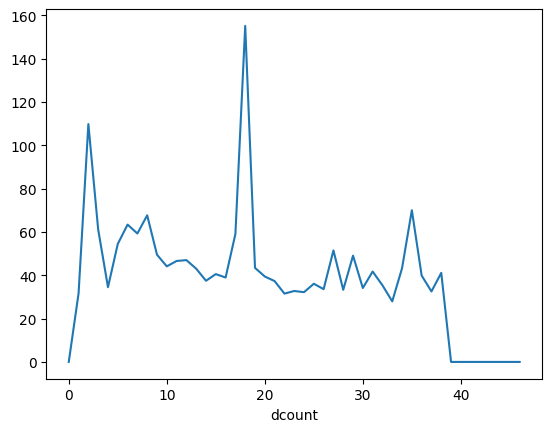

In [10]:
# plot again
lag = 1
raw[f'mbd_lag_{lag}'] = raw.groupby('cfips')['microbusiness_density'].shift(lag).bfill()
raw['dif'] = (raw['microbusiness_density'] / raw[f'mbd_lag_{lag}']).fillna(1).clip(0, None) - 1
raw.loc[(raw[f'mbd_lag_{lag}']==0), 'dif'] = 0
raw.loc[(raw[f'microbusiness_density']>0) & (raw[f'mbd_lag_{lag}']==0), 'dif'] = 1
raw['dif'] = raw['dif'].abs()
raw.groupby('dcount')['dif'].sum().plot()

<AxesSubplot: xlabel='dcount'>

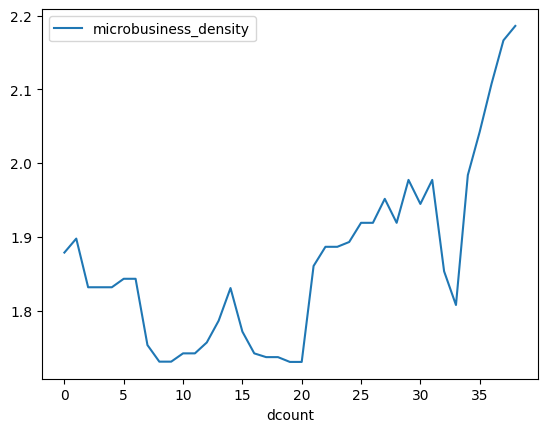

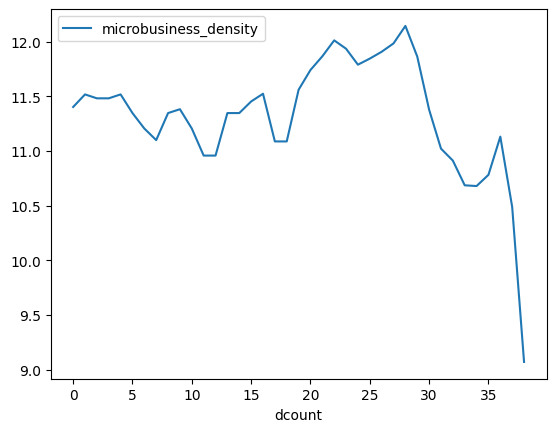

In [11]:
# plot two cfips density change over time
raw.loc[raw.cfips == 1013].plot(x='dcount', y='microbusiness_density')
raw.loc[raw.cfips == 21215].plot(x='dcount', y='microbusiness_density')

---

# 3. SMAPE is a relative metric so target must be converted.

**COLUMN 'target' is the next month increment compare to this month (in %)**

In [12]:
raw['target'] = raw.groupby('cfips')['microbusiness_density'].shift(-1)  # shift UP
raw['target'] = raw['target']/raw['microbusiness_density'] - 1   # next / this month - 1 = the next month increment
                                                                 # NOTE: dcount = 38 doesn't have target value - not next month to compare   
# two special cases, hard code to 0.0
raw.loc[raw['cfips']==28055, 'target'] = 0.0
raw.loc[raw['cfips']==48269, 'target'] = 0.0

<AxesSubplot: >

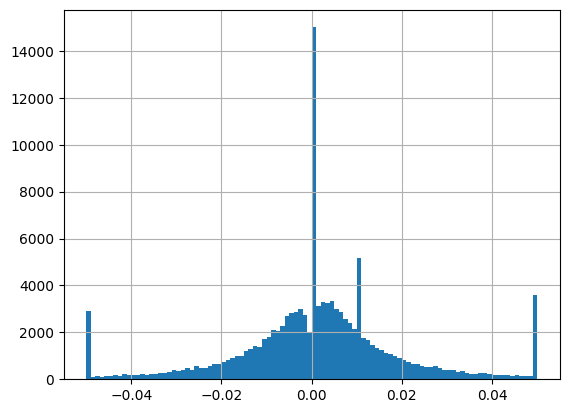

In [13]:
raw['target'].clip(-0.05, 0.05).hist(bins=100)

<AxesSubplot: >

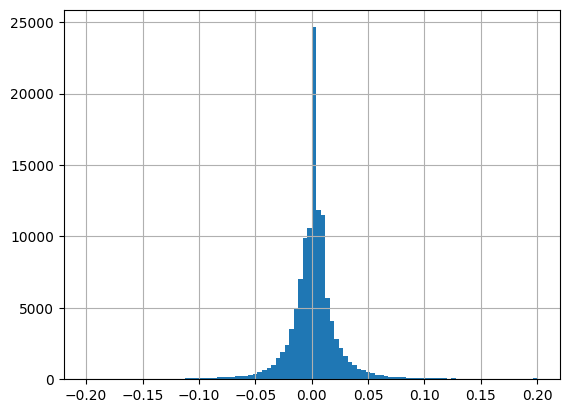

In [14]:
raw['target'].clip(-0.2, 0.2).hist(bins=100)

we can see that the increase to the next month usually exceed 20% of the current month.

**COLUMN 'lastactive'**

In [15]:
# for each cfips, get the last active value and assign it to the NEW column 'lastactive'
raw['lastactive'] = raw.groupby('cfips')['active'].transform('last')  

<AxesSubplot: >

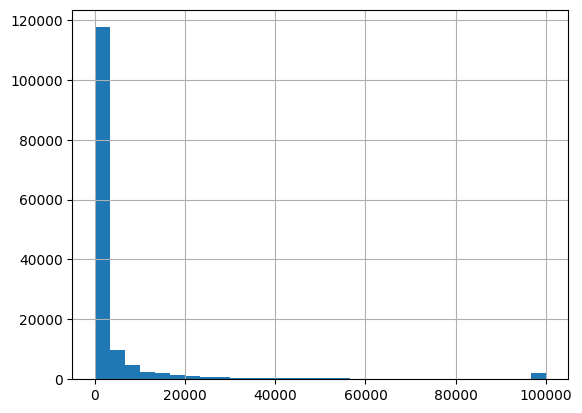

In [16]:
raw['lastactive'].clip(0, 100000).hist(bins=30)

**COLUMN 'lasttarget'**

In [17]:
# for each cfips, get dcount=28 (2021-12-01)'s density, so we get
#   cfips    2021-12-01's density
#   1001      3.286307
#   1003      7.930010
#         ...
# dt is a mapping table for the next step
dt = raw.loc[raw.dcount==28].groupby('cfips')['microbusiness_density'].agg('last')

# basically, use each cfips' 2021-12-01 density as the value for 'lasttarget' column 
# NOTE: this is the actual density value! not the target value. why 28?
raw['lasttarget'] = raw['cfips'].map(dt)

# 4. Feature Engineering

In [18]:
def build_features(raw, target='microbusiness_density', target_act='active_tmp', lags = 6):
    '''
    e.g.,
    target = 'target'
    target_act = 'active'
    lags = 4
    '''
    
    feats = []
    for lag in range(1, lags):  # 1 ~ 3
        
        # for each cfips, shift the 'target' column by 1,2 and 3
        # the original 'target' column has values from 0 to 37, note that dcount = 38 (2022-10-01) doesn't have a target value 
        raw[f'mbd_lag_{lag}'] = raw.groupby('cfips')[target].shift(lag)
        
        # for each cfips, the diff between the current avtive value and the previous 1,2,and 3 months' active values
        # the original 'active' column has values from 0 to 38
        raw[f'act_lag_{lag}'] = raw.groupby('cfips')[target_act].diff(lag)
        
        # the shifted 'target' and 'active' are taken as features
        # basically, for each month, the previous 1,2,3 months' target and active are taken into consideration
        feats.append(f'mbd_lag_{lag}')
        feats.append(f'act_lag_{lag}')
    
    # the sum of the previous 2,4,6 months 'target' value
    lag = 1
    for window in [2, 4, 6]:
        raw[f'mbd_rollmea{window}_{lag}'] = raw.groupby('cfips')[f'mbd_lag_{lag}'].transform(lambda s: s.rolling(window, min_periods=1).sum())   
        
        ## the diff between the previous month and the sum of previous 6 months. the original notebook doesn't use it
        ##raw[f'mbd_rollmea{window}_{lag}'] = raw[f'mbd_lag_{lag}'] - raw[f'mbd_rollmea{window}_{lag}']
        
        feats.append(f'mbd_rollmea{window}_{lag}')
        
    return raw, feats

In [19]:
# Build Features based in lag of target
raw, feats = build_features(raw, 'target', 'active', lags = 4)

# the state code is a feature
features = ['state_i']
features += feats
print(features)

raw.loc[raw.dcount==38, features].head(10)

['state_i', 'mbd_lag_1', 'act_lag_1', 'mbd_lag_2', 'act_lag_2', 'mbd_lag_3', 'act_lag_3', 'mbd_rollmea2_1', 'mbd_rollmea4_1', 'mbd_rollmea6_1']


,state_i,mbd_lag_1,act_lag_1,mbd_lag_2,act_lag_2,mbd_lag_3,act_lag_3,mbd_rollmea2_1,mbd_rollmea4_1,mbd_rollmea6_1
38,0,0.006152,9.0,0.005498,17.0,-0.004107,11.0,0.011650,0.034969,0.027467
85,0,0.002170,31.0,-0.017601,-225.0,-0.009601,-366.0,-0.015431,-0.017278,0.049618
132,0,0.020921,5.0,0.008439,7.0,-0.016597,3.0,0.029359,0.033948,0.033966
179,0,-0.021367,-5.0,0.017391,-1.0,-0.025424,-7.0,-0.003976,0.010248,0.028286
226,0,-0.010949,-9.0,0.008589,-2.0,0.002460,0.0,-0.002360,0.033137,0.038372
273,0,0.012987,1.0,0.013158,2.0,0.013333,3.0,0.026145,0.052992,0.080770
320,0,0.009036,3.0,0.027864,12.0,0.031949,22.0,0.036900,0.098454,0.171279
367,0,-0.003180,-8.0,0.007609,11.0,0.002006,16.0,0.004429,0.027747,0.034010
414,0,-0.040201,-16.0,-0.012407,-21.0,-0.017073,-28.0,-0.052608,-0.015697,-0.023285
461,0,-0.012605,-3.0,0.000000,-3.0,-0.008333,-5.0,-0.012605,0.000338,-0.098884


<AxesSubplot: >

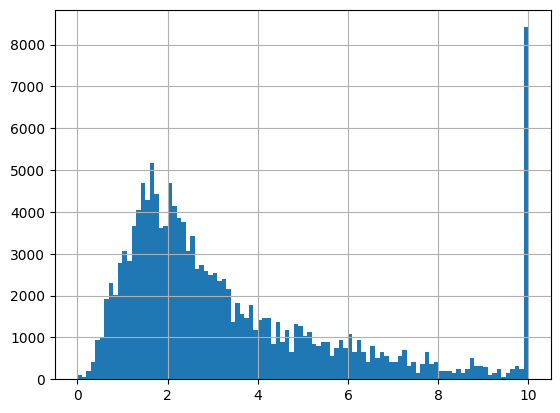

In [20]:
# why do we have to care about 'lasttarget'?
# ' basically, use each cfips' 2021-12-01 density as the value for 'lasttarget' column 
#   NOTE: this is the actual density value! not the target value. why 28?'
raw['lasttarget'].clip(0,10).hist(bins=100)

# 5. MODEL

What's the meaning of the blacklist? how to get it? see section 6

In [21]:
blacklist = [
    'North Dakota', 'Iowa', 'Kansas', 'Nebraska', 'South Dakota','New Mexico', 'Alaska', 'Vermont'
]
blacklistcfips = [
1019,1027,1029,1035,1039,1045,1049,1057,1067,1071,1077,1085,1091,1099,1101,1123,1131,1133,4001,4012,4013,4021,4023,5001,5003,5005,5017,5019,5027,5031,5035,5047,5063,5065,5071,5081,5083,5087,5091,5093,5107,5109,5115,5121,5137,5139,5141,5147,6003,6015,6027,6033,6053,6055,6057,6071,6093,6097,6103,6105,6115,8003,8007,8009,8019,8021,8023,8047,8051,8053,8055,8057,8059,8061,8065,8067,8069,8071,8073,8075,8085,8091,8093,8097,8099,8103,8105,8107,8109,8111,8115,8117,8121,9007,9009,9015,12009,12017,12019,12029,12047,12055,12065,12075,12093,12107,12127,13005,13007,13015,13017,13019,13027,13035,13047,13065,13081,13083,13099,13107,13109,13117,13119,13121,13123,13125,13127,13135,13143,13147,13161,13165,13171,13175,13181,13193,13201,13221,13225,13229,13231,13233,13245,13247,13249,13257,13279,13281,13287,13289,13293,13301,13319,15001,15005,15007,16001,16003,16005,16007,16013,16015,16017,16023,16025,16029,16031,16033,16035,16037,16043,16045,16049,16061,16063,16067,17001,17003,17007,17009,17013,17015,17023,17025,17031,17035,17045,17051,17059,17061,17063,17065,17067,17069,17075,17077,17081,17085,17087,17103,17105,17107,17109,17115,17117,17123,17127,17133,17137,17141,17143,17147,17153,17167,17169,17171,17177,17179,17181,17185,17187,17193,18001,18007,18009,18013,18015,18019,18021,18025,18035,18037,18039,18041,18053,18061,18075,18079,18083,18087,18099,18103,18111,18113,18115,18137,18139,18145,18153,18171,18179,21001,21003,21013,21017,21023,21029,21035,21037,21039,21045,21047,21055,21059,21065,21075,21077,21085,21091,21093,21097,21099,21101,21103,21115,21125,21137,21139,21141,21149,21155,21157,21161,21165,21179,21183,21191,21197,21199,21215,21217,21223,21227,21237,21239,22019,22021,22031,22039,22041,22047,22069,22085,22089,22101,22103,22109,22111,22115,22119,22121,23003,23009,23021,23027,23029,24011,24027,24029,24031,24035,24037,24039,24041,25011,25015,26003,26007,26011,26019,26021,26025,26027,26033,26037,26041,26043,26051,26053,26057,26059,26061,26065,26071,26077,26079,26083,26089,26097,26101,26103,26109,26111,26115,26117,26119,26127,26129,26131,26135,26141,26143,26155,26161,26165,27005,27011,27013,27015,27017,27021,27023,27025,27029,27047,27051,27055,27057,27065,27069,27073,27075,27077,27079,27087,27091,27095,27101,27103,27105,27107,27109,27113,27117,27119,27123,27125,27129,27131,27133,27135,27141,27147,27149,27155,27159,27167,27169,28017,28019,28023,28025,28035,28045,28049,28061,28063,28093,28097,28099,28125,28137,28139,28147,28159,29001,29015,29019,29031,29033,29041,29049,29051,29055,29057,29063,29065,29069,29075,29085,29089,29101,29103,29111,29121,29123,29125,29135,29137,29139,29143,29157,29159,29161,29167,29171,29173,29175,29177,29183,29195,29197,29199,29203,29205,29207,29209,29213,29215,29217,29223,29227,29229,30005,30009,30025,30027,30033,30035,30037,30039,30045,30049,30051,30053,30055,30057,30059,30069,30071,30073,30077,30079,30083,30085,30089,30091,30093,30101,30103,30105,30107,30109,32005,32009,32017,32023,32027,32029,32510,33005,33007,34021,34027,34033,34035,36011,36017,36023,36033,36043,36047,36049,36051,36057,36061,36067,36083,36091,36097,36103,36107,36113,36115,36121,36123,37005,37009,37011,37017,37023,37029,37031,37049,37061,37075,37095,37117,37123,37131,37137,37151,37187,37189,37197,39005,39009,39015,39017,39019,39023,39037,39039,39043,39049,39053,39057,39063,39067,39071,39077,39085,39087,39091,39097,39105,39107,39113,39117,39119,39125,39127,39129,39135,39137,39151,39153,39157,40003,40013,40015,40023,40025,40027,40035,40039,40043,40045,40053,40055,40057,40059,40065,40067,40073,40077,40079,40099,40105,40107,40111,40115,40123,40127,40129,40133,40141,40147,40151,40153,41001,41007,41013,41015,41017,41021,41025,41031,41033,41037,41051,41055,41063,41067,41069,42005,42007,42011,42013,42015,42019,42027,42029,42031,42035,42053,42057,42067,42071,42083,42085,42093,42097,42105,42111,42113,42115,42123,42125,42127,42129,44005,44007,44009,45001,45009,45021,45025,45031,45059,45067,45071,45073,45089,47001,47005,47013,47015,47019,47021,47023,47027,47035,47039,47041,47047,47055,47057,47059,47061,47069,47073,47075,47077,47083,47087,47099,47105,47121,47127,47131,47133,47135,47137,47147,47151,47153,47159,47161,47163,47169,47177,47183,47185,48001,48011,48017,48019,48045,48057,48059,48063,48065,48073,48077,48079,48081,48083,48087,48095,48101,48103,48107,48109,48115,48117,48119,48123,48125,48129,48149,48151,48153,48155,48159,48161,48165,48175,48189,48191,48195,48197,48211,48221,48229,48233,48235,48237,48239,48241,48243,48245,48255,48261,48263,48265,48267,48269,48275,48277,48283,48293,48299,48305,48311,48313,48319,48321,48323,48327,48333,48345,48347,48355,48369,48377,48379,48383,48387,48389,48401,48403,48413,48417,48431,48433,48437,48443,48447,48453,48455,48457,48461,48463,48465,48469,48471,48481,48483,48485,48487,48495,48499,49001,49009,49013,49019,49027,49031,49045,51005,51017,51025,51029,51031,51036,51037,51043,51057,51059,51065,51071,51073,51077,51079,51083,51091,51095,51097,51101,51111,51115,51119,51121,51127,51135,51147,51155,51159,51165,51167,51171,51173,51181,51183,51191,51197,51530,51590,51610,51620,51670,51678,51720,51735,51750,51770,51810,51820,53013,53019,53023,53031,53033,53037,53039,53041,53047,53065,53069,53071,53075,54013,54019,54025,54031,54033,54041,54049,54055,54057,54063,54067,54071,54077,54079,54085,54089,54103,55001,55003,55005,55007,55011,55017,55021,55025,55029,55037,55043,55047,55049,55051,55061,55065,55067,55075,55077,55091,55097,55101,55103,55109,55117,55123,55125,55127,56007,56009,56011,56015,56017,56019,56021,56027,56031,56037,56043,56045,
12061,  6095, 49025, 18073, 29029, 29097, 48419, 51830, 30067, 26095, 18159, 32001, 54065, 54027, 13043, 48177, 55069, 48137, 30087, 29007, 13055, 48295, 28157, 29037, 45061, 22053, 13199, 47171, 53001, 55041, 51195, 18127, 29151, 48307, 51009, 16047, 29133,  5145, 17175, 21027, 48357, 29179, 13023, 16077, 48371, 21057, 16039, 21143, 48435, 48317, 48475,  5129, 36041, 48075, 29017, 47175, 39167, 47109, 17189, 17173, 28009, 39027, 48133, 18129, 48217, 40081, 36021,  6005, 42099, 18051, 36055, 53051, 6109, 21073, 27019,  6051, 48055,  8083, 48503, 17021, 10003, 41061, 22001, 22011, 21205, 48223, 51103, 51047, 16069, 17033, 41011,  6035, 47145, 27083, 18165, 36055, 12001, 26159,  8125, 34017,
28141, 55119, 48405, 40029, 18125, 21135, 29073, 55115, 37149,55039, 26029, 12099, 13251, 48421, 39007, 41043, 22015, 37115,54099, 51137, 22049, 55131, 17159, 56001, 40005, 18017, 28091,47101, 27037, 29005, 13239, 21019, 55085, 48253, 51139, 40101,13283, 18049, 39163, 45049, 51113,
]

In [22]:
# threshold
ACT_THR = 1.8
ABS_THR = 1.0

# define 3 new columns for use
raw['ypred_last'] = np.nan
raw['ypred'] = np.nan
raw['k'] = 1.

VAL = []
BEST_ROUNDS = []

In [24]:
raw.loc[:5, features], raw.loc[:5, 'target'].clip(-0.0043, 0.0045)

(   state_i  mbd_lag_1  act_lag_1  mbd_lag_2  act_lag_2  mbd_lag_3  act_lag_3  \
 0        0        NaN        NaN        NaN        NaN        NaN        NaN   
 1        0   0.010101      -51.0        NaN        NaN        NaN        NaN   
 2        0   0.059265       71.0   0.010101       20.0        NaN        NaN   
 3        0  -0.020489      -26.0   0.059265       45.0   0.010101       -6.0   
 4        0   0.000000        0.0  -0.020489      -26.0   0.059265       45.0   
 5        0  -0.008066       -1.0   0.000000       -1.0  -0.020489      -27.0   
 
    mbd_rollmea2_1  mbd_rollmea4_1  mbd_rollmea6_1  
 0             NaN             NaN             NaN  
 1        0.010101        0.010101        0.010101  
 2        0.069366        0.069366        0.069366  
 3        0.038777        0.048878        0.048878  
 4       -0.020489        0.048878        0.048878  
 5       -0.008066        0.030711        0.040812  ,
 0    0.0045
 1    0.0045
 2   -0.0043
 3    0.0000
 4   -0

In [23]:
for TS in range(29, 38):  # from 29 to 37.  1) is it the reason why 'lasttarget' use 'dcount=28'?  
                          # the actual density pred you give is 30 to 38  
    print(TS)
    
    # --- define the model
    model = xgb.XGBRegressor(
        objective='reg:pseudohubererror',   # why this objective?
        #objective='reg:squarederror',
        tree_method="hist",                 # 
        n_estimators=4999,                  # iterations
        learning_rate=0.0075,
        max_leaves = 17,    
        subsample=0.50,                     # sample used for each iteration
        colsample_bytree=0.50,              # features used for each iteration
        max_bin=4096,                       # 
        n_jobs=2,
        eval_metric='mae',                  # 
        early_stopping_rounds=70,
    )
    
    # --- get training data
    train_indices = (raw.istest==0) & (raw.dcount  < TS) & (raw.dcount >= 1) & (raw.lastactive>ACT_THR) & (raw.lasttarget>ABS_THR) 
    #                no test data   |    training month = [1,TS)             |                   1.8     |                    1
    #                                    why not use 0?                                                              
    #                                    because has undefined features, but does 1 has all the features?
    # 
    # note that for each cfips, the 'lastactive' across months are the same, so does the 'lasttarget' column
    # so, you either select all the rows or drop all the row for a cfips
    #
    # ‘lasttarget’: for each cfips, the density in dcount = 28 '2021-12-01'
    # 'lastactive': for each cfips, the last active value (in dcount = 38)  '2022-10-01'
    
    # --- get testing data
    valid_indices = (raw.istest==0) & (raw.dcount == TS)  # note: more cfips than training data, but we exclude some of them later
    
    # --- model fit
    model.fit(
        raw.loc[train_indices, features],
        raw.loc[train_indices, 'target'].clip(-0.0043, 0.0045),    # why clip ? the increase or decrease is confined in the range (-0.0043, 0.0045). reasonable?
        eval_set=[(raw.loc[valid_indices, features], raw.loc[valid_indices, 'target'])],
        verbose=500,
    )
    
    # --- save best iteration
    best_rounds = model.best_iteration
    BEST_ROUNDS.append(model.best_iteration)
    
    # --- pred the current validation set, note the pred is the increment comparing to TS+1
    ypred = model.predict(raw.loc[valid_indices, features])
    
    # becasue we pred the increment for the next month, so we need to add 1
    raw.loc[valid_indices, 'k'] = ypred + 1
    # if you multiple it with 'density' in TS, you get next month TS+1 density prediction
    raw.loc[valid_indices, 'k'] = raw.loc[valid_indices,'k'] * raw.loc[valid_indices,'microbusiness_density']

    # --- ACTUALLY, WE ARE PREDICTING **TS+1** ---
    # 1. define two mappings, lastval and dt
    lastval = raw.loc[raw.dcount==TS, ['cfips', 'microbusiness_density']].set_index('cfips').to_dict()['microbusiness_density']
    # for all the current validation TS, get cfips and density
    # then, set cfips to index, so we make a dict -> cfips: the density for TS
    # e.g., { 'microbusiness_density':{1001: 3.2967808, 1003: 7.733397, 1005: 1.1866289, ...} }
    # this is a map for later use
    
    dt = raw.loc[raw.dcount==TS, ['cfips', 'k']].set_index('cfips').to_dict()['k']
    # e.g., { 'k':{1001: pred for TS+1 month ACTUAL density, 1003: , 1005: , ...} }
    # this is a map for later use
    
    # 2. define a tmp dataframe for the preds of TS+1
    df = raw.loc[raw.dcount==(TS+1), ['cfips', 'microbusiness_density', 'state', 'lastactive', 'mbd_lag_1']].reset_index(drop=True)
    # get all the cfips's TS+1                                         the 2022-10-01 active |  'target' value in TS
    
    # ATTACH the mappings to df columns
    df['pred'] = df['cfips'].map(dt)         # put TS+1 density pred to 'pred' column of the TS+1 specific df
    df['lastval'] = df['cfips'].map(lastval) # put the TS density to 'lastval' column of df
    
    # FOR SOME CASES, WE DON'T WANT TO USE THE PREDICTIONS BY THE MODEL, INSTEAD, WE WANT TO USE THE TS DENSITY.
    # case1. for each cfips, if the last active in dcount=38 is smaller than ACT_THR, (which means the business scale is considered as small)
    #    then, we don't use the pred above, instead, use the TS density
    df.loc[df['lastactive']<=ACT_THR, 'pred'] = df.loc[df['lastactive']<=ACT_THR, 'lastval']
    
    # case2. for each cfips, if the TS actual density is smaller than ABS_THR, (which means the recent trend is small?)
    #    then, we don't use the pred above, instead, use the TS density
    df.loc[df['lastval']<=ABS_THR, 'pred'] = df.loc[df['lastval']<=ABS_THR, 'lastval']
    
    # case3. if the state is in the black list, then we don't use the pred above, instead, use the TS density
    #        how to get this blacklist?
    df.loc[df['state'].isin(blacklist), 'pred'] = df.loc[df['state'].isin(blacklist), 'lastval']
    
    # case4. if the cfips is in the black list, then we don't use the pred above, instead, use the TS density
    df.loc[df['cfips'].isin(blacklistcfips), 'pred'] = df.loc[df['cfips'].isin(blacklistcfips), 'lastval']
    
    # FINALLY, assign the pred to the 'ypred' column of the 'raw' dataframe
    raw.loc[raw.dcount==(TS+1), 'ypred'] = df['pred'].values
    #          lastval is the actual density in TS, basically, you shift lag=1
    raw.loc[raw.dcount==(TS+1), 'ypred_last'] = df['lastval'].values
    
    print(f'TS: {TS}')
    print('Last Value SMAPE:', smape(df['microbusiness_density'], df['lastval']) )   # smape if you simply use last density to predict TS+1
    print('XGB SMAPE:', smape(df['microbusiness_density'], df['pred']))              # smape if you use the preds
    print()


ind = (raw.dcount >= 30)&(raw.dcount <= 38)
print( 'XGB SMAPE:', smape( raw.loc[ind, 'microbusiness_density'],  raw.loc[ind, 'ypred'] ) )
print( 'Last Value SMAPE:', smape( raw.loc[ind, 'microbusiness_density'],  raw.loc[ind, 'ypred_last'] ) )

29


ImportError: sklearn needs to be installed in order to use this module

In [ ]:
raw['error'] = vsmape(raw['microbusiness_density'], raw['ypred'])
raw['error_last'] = vsmape(raw['microbusiness_density'], raw['ypred_last'])
raw.loc[(raw.dcount==30), ['cfips', 'microbusiness_density', 'ypred', 'ypred_last','error', 'error_last'] ].head(10)

# 6. Some post-hoc analysis after training and validation

## 6.1 which state has the most significant diff between the error (by pred) and the error_last (by last value pred)

for example, it is better to use the actual xgb prediction for the district of columbia, instead of the last prediction.

In [ ]:
dt = raw.loc[(raw.dcount>=30)&(raw.dcount<=38) ].groupby('state')['error', 'error_last'].mean()
dt['hit'] = dt['error'] - dt['error_last']
dt = dt.sort_values('hit', ascending=True)
dt

In [ ]:
dt.iloc[-10:,:]

THIS IS WHERE THE BLACK LIST COMES FROM!!!

## 6.2 which month has the biggest error

In [ ]:
dt = raw.loc[(raw.dcount>=30)&(raw.dcount<=38) ].groupby('dcount')['error', 'error_last'].mean()
dt['hit'] = dt['error'] - dt['error_last']
dt = dt.sort_values('hit', ascending=False)
dt.loc[dt['hit']>0]
dt

# 6.3 stat err for each cfips and dcount, find out which dcount in which cfips has the biggest error diff between error_last and error

In [ ]:
dt = raw.loc[(raw.dcount>=30)&(raw.dcount<=38) ].groupby(['cfips','dcount'])['error', 'error_last'].mean()
dt['hit'] = dt['error'] - dt['error_last']
dt = dt.sort_values('hit', ascending=False).reset_index()
dt.loc[dt['hit']>0]
dt.head(20)

TOP 300 cfips with big diff, maybe duplicate inside

In [ ]:
dt.loc[dt['hit']>0].cfips.values[:300]

## 6.4 TOP county that shouldn't use pred. instead, we should use last_value!

In [ ]:
dt = raw.loc[(raw.dcount>=30)&(raw.dcount<=38) ].groupby('cfips')['error', 'error_last'].mean()
dt['hit'] = dt['error'] - dt['error_last']
dt = dt.sort_values('hit', ascending=False)
dt = dt.loc[dt['hit']>0.00]
dt

In [ ]:
dt.index

## 6.5

In [ ]:
dt = raw.loc[(raw.dcount>=30)&(raw.dcount<=38) ].groupby(['cfips','dcount'])['error', 'error_last'].last()
dt['miss'] = dt['error'] > dt['error_last']
dt

**for each county, the % that our XGB pred does worse than last preds**

In [ ]:
dt = dt.groupby('cfips')['miss'].mean()
dt

**if 50% XGB preds is worse than the last pred, show me these county**

In [ ]:
dt = dt.loc[dt>=0.50]
dt.index

In [ ]:
','.join([str(i) for i in dt.index])

In [ ]:
# show me the preds, WHY WHERE IS A LAG?????
for d in dt.index[:10]:
    raw.loc[raw.cfips==d].plot(x='dcount', y=['microbusiness_density', 'ypred'], title=str(d))
    #raw.loc[raw.cfips==d].plot(x='dcount', y=['microbusiness_density', 'ypred_last'], title=str(d))

## 6.6

In [ ]:
df = raw.loc[(raw.dcount>=30)&(raw.dcount<=38) ].copy().reset_index(drop=True)
print( smape(df['microbusiness_density'], df['ypred']) )

In [ ]:
dt = df.groupby(['cfips','dcount'])['error', 'error_last'].sum()
dt['hit'] = 1*(dt['error'] < dt['error_last'])
dt

In [ ]:
dt = dt.groupby('cfips')['hit'].mean().sort_values(ascending=True)
dt

In [ ]:
# top 800 county that should use last_value prediction, NOT XGB predictions
toplist = list(dt.index[:800])
#print(toplist)

# 
df.loc[df.cfips.isin(toplist), 'ypred'] = df.loc[df.cfips.isin(toplist), 'ypred_last']
print( smape(df['microbusiness_density'], df['ypred']) )

# 7. LET'S GET THE PREDICTIONS FOR TS=38+1, WHICH IS 2022-11-01

In [ ]:
np.mean( BEST_ROUNDS ), np.median( BEST_ROUNDS ), BEST_ROUNDS

In [ ]:
best_rounds = int(np.median( BEST_ROUNDS )+1)
best_rounds

In [ ]:
TS = 38
print(TS)

model0 = xgb.XGBRegressor(
    objective='reg:pseudohubererror',
    #objective='reg:squarederror',
    tree_method="hist",
    n_estimators=best_rounds,  # now we have best round, so no early stopping
    learning_rate=0.0075,
    max_leaves = 31,           # the model used above has 17
    subsample=0.60,            # the model used above has 0.50 
    colsample_bytree=0.50,     
    max_bin=4096,
    n_jobs=2,
    eval_metric='mae',           
)

model1 = xgb.XGBRegressor(
    objective='reg:pseudohubererror',
    #objective='reg:squarederror',
    tree_method="hist",
    n_estimators=best_rounds,
    learning_rate=0.0075,
    max_leaves = 31,
    subsample=0.60,
    colsample_bytree=0.50,
    max_bin=4096,
    n_jobs=2,
    eval_metric='mae',
)

train_indices = (raw.istest==0) & (raw.dcount  < TS) & (raw.dcount >= 1) & (raw.lastactive>ACT_THR)  & (raw.lasttarget>ABS_THR) 
valid_indices = (raw.dcount == TS)

# I don't understand why we need two identical models. and then do a half / half ensemble
model0.fit(
    raw.loc[train_indices, features],
    raw.loc[train_indices, 'target'].clip(-0.0044, 0.0046),
)

model1.fit(
    raw.loc[train_indices, features],
    raw.loc[train_indices, 'target'].clip(-0.0044, 0.0046),
)

ypred = (model0.predict(raw.loc[valid_indices, features]) + model1.predict(raw.loc[valid_indices, features])) / 2

raw.loc[valid_indices, 'k'] = ypred + 1.
raw.loc[valid_indices,'k'] = raw.loc[valid_indices,'k'] * raw.loc[valid_indices,'microbusiness_density'] # this is the pred for TS+1 = 39, although it is at TS

# two mappings
# 1. each cfips' microbusiness density in TS
lastval = raw.loc[raw.dcount==TS, ['cfips', 'microbusiness_density']].set_index('cfips').to_dict()['microbusiness_density']
# 2. each cfips' TS+1 prediction
dt = raw.loc[raw.dcount==TS, ['cfips', 'k']].set_index('cfips').to_dict()['k']

In [ ]:
df = raw.loc[raw.dcount==(TS+1), ['cfips', 'microbusiness_density', 'state', 'lastactive', 'mbd_lag_1']].reset_index(drop=True)
df

In [ ]:
df['pred'] = df['cfips'].map(dt)           # assign predictions to TS+1
df['lastval'] = df['cfips'].map(lastval)   # assign TS density values

In [ ]:
df.loc[df['lastactive']<=ACT_THR, 'pred'] = df.loc[df['lastactive']<=ACT_THR, 'lastval']
df.loc[df['lastval']<=ABS_THR, 'pred'] = df.loc[df['lastval']<=ABS_THR, 'lastval']
df.loc[df['state'].isin(blacklist), 'pred'] = df.loc[df['state'].isin(blacklist), 'lastval']
df.loc[df['cfips'].isin(blacklistcfips), 'pred'] = df.loc[df['cfips'].isin(blacklistcfips), 'lastval']
raw.loc[raw.dcount==(TS+1), 'ypred'] = df['pred'].values
raw.loc[raw.dcount==(TS+1), 'ypred_last'] = df['lastval'].values

In [ ]:
raw[['cfips','microbusiness_density','dcount','ypred','ypred_last','k']].head(50)

In [ ]:
raw.loc[raw['cfips']==28055, 'microbusiness_density'] = 0
raw.loc[raw['cfips']==48269, 'microbusiness_density'] = 1.762115

dt = raw.loc[raw.dcount==39, ['cfips', 'ypred']].set_index('cfips').to_dict()['ypred']
test = raw.loc[raw.istest==1, ['row_id', 'cfips','microbusiness_density']].copy()
test['microbusiness_density'] = test['cfips'].map(dt)

test[['row_id','microbusiness_density']].to_csv('submission.csv', index=False)
test.head(50)